# TASK Object Localization

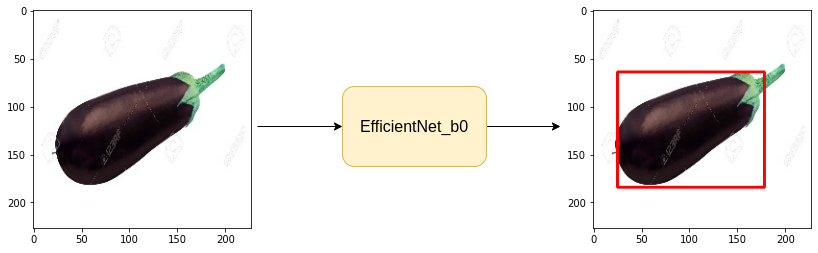

In [2]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-puxh9pyh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-puxh9pyh
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [3]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [6]:
import pandas as pd

# File paths
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

# Device settings
DEVICE = 'cuda'

# Model parameters
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40

# Other constants
NUM_COR = 4

In [7]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

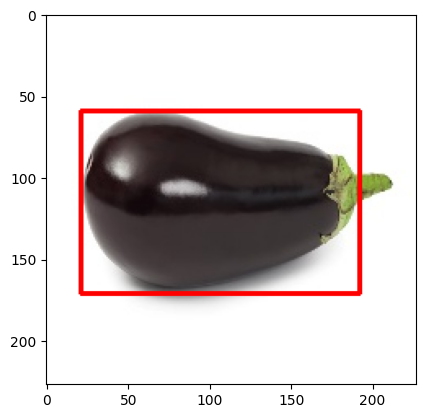

In [8]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [10]:
import albumentations as A

In [11]:
IMG_SIZE = 224

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [12]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        self.label_map = {"mushroom": 0, "eggplant": 1, "cucumber": 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]
        img_path = DATA_DIR + row.img_path

        label = self.label_map[row.label]
        label = torch.tensor(label, dtype=torch.long)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[label.item()])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0  # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)
        label = torch.Tensor(label)

        return img, bbox, label

In [13]:
trainset = ObjLocDataset(train_df, augmentations=train_augs)
validset = ObjLocDataset(valid_df, augmentations=valid_augs)

In [14]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


tensor(0)


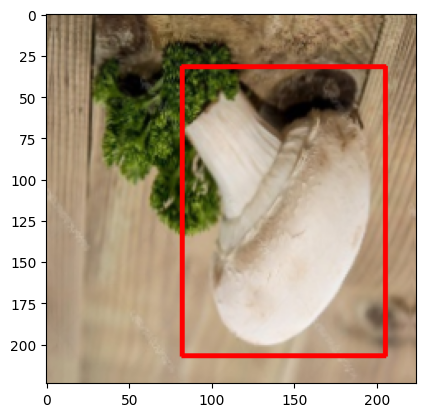

In [15]:
img, bbox, label = trainset[88]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
print(label)

# Load dataset into batches

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [19]:
for images,bboxes,label in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))
print("label_shape", print(label.shape))

Shape of one batch images : torch.Size([16, 3, 224, 224])
Shape of one batch bboxes : torch.Size([16, 4])
torch.Size([16])
label_shape None


# Create Model

In [20]:
from torch import nn
import timm

In [21]:
class CustomObjLocModel(nn.Module):
    def __init__(self):
        super(CustomObjLocModel, self).__init__()

        # Replace this with your custom convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Replace this with your custom dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.relu3 = nn.ReLU()
        self.fc_bbox = nn.Linear(256, 4)  # Output layer with 4 nodes for bounding box coordinates
        self.fc_class = nn.Linear(256, 3) # jusrt labels



    def forward(self, images, gt_bboxes=None, label=None):
        x = self.conv1(images)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        bboxes = self.fc_bbox(x)
        labels_pred = self.fc_class(x)

        if gt_bboxes is not None:
            loss_fn1 = nn.MSELoss()
            loss_bbox = loss_fn1(bboxes, gt_bboxes)
            loss_fn2 = nn.CrossEntropyLoss()
            class_loss = loss_fn2(labels_pred, label)
            # Combine both losses
            total_loss = loss_bbox + class_loss
            return bboxes, labels_pred, total_loss

        return bboxes

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomObjLocModel()
model.to(DEVICE)

CustomObjLocModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=401408, out_features=256, bias=True)
  (relu3): ReLU()
  (fc_bbox): Linear(in_features=256, out_features=4, bias=True)
  (fc_class): Linear(in_features=256, out_features=3, bias=True)
)

In [23]:
random_img = torch.rand(1, 3, 224, 224).to(DEVICE)
output_shape = model(random_img).shape

print("Model output shape:", output_shape)


Model output shape: torch.Size([1, 4])


# Create Train and Eval Function

In [24]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()  # Dropout ON

    for data in tqdm(dataloader):
        images, gt_bboxes, label = data
        images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)

        bboxes,label, loss = model(images, gt_bboxes, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [25]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()  # Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes, label = data
            images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)

            bboxes,label, loss = model(images, gt_bboxes, label)
            total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss

    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 | Train Loss: 5722.69248046875 | Valid Loss: 1145.925801595052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 | Train Loss: 1301.6810791015625 | Valid Loss: 812.2013346354166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 757.4191955566406 | Valid Loss: 1047.3452758789062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 | Train Loss: 665.7460968017579 | Valid Loss: 652.9454956054688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 | Train Loss: 612.7372253417968 | Valid Loss: 586.6500549316406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 602.4133697509766 | Valid Loss: 609.6475219726562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 553.0152160644532 | Valid Loss: 706.5977579752604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 8 | Train Loss: 637.4197601318359 | Valid Loss: 515.7068277994791


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 551.5717025756836 | Valid Loss: 577.3929646809896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 547.4157928466797 | Valid Loss: 634.2129211425781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 583.3980041503906 | Valid Loss: 760.1396891276041


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 607.3444702148438 | Valid Loss: 593.497080485026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 13 | Train Loss: 558.8221405029296 | Valid Loss: 480.1718037923177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 14 | Train Loss: 512.8236938476563 | Valid Loss: 463.87774658203125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 550.6841766357422 | Valid Loss: 493.91405232747394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 494.76597290039064 | Valid Loss: 481.65570068359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 490.5747802734375 | Valid Loss: 520.0040995279948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 600.2824523925781 | Valid Loss: 471.4853108723958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 531.5726867675781 | Valid Loss: 471.5579528808594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 512.459194946289 | Valid Loss: 483.59885660807294


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 573.1096282958985 | Valid Loss: 586.741455078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 22 | Train Loss: 507.28013916015624 | Valid Loss: 417.0268046061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 487.2907318115234 | Valid Loss: 506.9393310546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 567.9135559082031 | Valid Loss: 878.2271728515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 561.5287933349609 | Valid Loss: 604.6473795572916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 571.9379974365235 | Valid Loss: 638.2987060546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 526.3351928710938 | Valid Loss: 523.8783976236979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 447.35426330566406 | Valid Loss: 521.796142578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 494.76082305908204 | Valid Loss: 443.25926717122394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 531.0431823730469 | Valid Loss: 476.75208536783856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 666.7311889648438 | Valid Loss: 476.6564534505208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 468.6963348388672 | Valid Loss: 626.8185017903646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 511.42201843261716 | Valid Loss: 654.4953816731771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 34 | Train Loss: 511.76874084472655 | Valid Loss: 414.6105143229167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 470.96063537597655 | Valid Loss: 531.9403279622396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 518.5906433105469 | Valid Loss: 511.4213460286458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 515.3110961914062 | Valid Loss: 420.5439961751302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 404.7936981201172 | Valid Loss: 415.46277872721356


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 39 | Train Loss: 383.98040466308595 | Valid Loss: 396.1368408203125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 40 | Train Loss: 369.23916091918943 | Valid Loss: 392.21985880533856


#Inference

In [28]:
import utils

tensor(1)


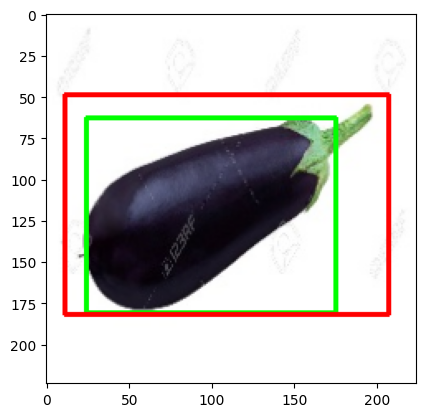

In [38]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


# Perform inference
with torch.no_grad():
    image, gt_bbox, label = validset[4]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)
    print(label)
    utils.compare_plots(image, gt_bbox, out_bbox)
